In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import datetime as dt
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [2]:
df_items = pd.read_csv("final_data/orders_items.csv", index_col=0)
df_reviews = pd.read_csv("final_data/order_reviews.csv", index_col=0)
df_orders = pd.read_csv("final_data/orders.csv", index_col=0)
df_products = pd.read_csv("final_data/products.csv", index_col=0)
df_geolocation = pd.read_csv("final_data/geolocation.csv", index_col=0)
df_sellers = pd.read_csv("final_data/sellers.csv", index_col=0)
df_payments = pd.read_csv("final_data/order_payments.csv", index_col=0)
df_customers = pd.read_csv("final_data/customers.csv", index_col=0)
df_category = pd.read_csv("final_data/product_category_name_translation.csv", index_col=0)

### orders

In [4]:
df_orders.reset_index(inplace=True)
df_orders.dropna(inplace=True)
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,9ef432eb-6251-2973-04e7-6186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc-8bc7-dce0-b674-1e2150273451,b0830fb4-747a-6c6d-20de-a0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9-100c-2d0c-4494-6d9cf07ec65d,41ce2a54-c0b0-3bf3-443c-3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44-dbf5-de91-8fe9-c16f97b45f8a,f8819746-5ea7-920a-dcdb-ec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c-0840-e6cb-83a9-ceb5573f8159,8ab97904-e6da-ea88-66db-dbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [5]:
# Учитываем только данные по доставленным заказам
df_orders = df_orders[df_orders['order_status']=='delivered']
print("'Order status'-column values:", (df_orders['order_status'].unique()))
df_orders.info()

'Order status'-column values: ['delivered']
<class 'pandas.core.frame.DataFrame'>
Index: 96455 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96455 non-null  object
 1   customer_id                    96455 non-null  object
 2   order_status                   96455 non-null  object
 3   order_purchase_timestamp       96455 non-null  object
 4   order_approved_at              96455 non-null  object
 5   order_delivered_carrier_date   96455 non-null  object
 6   order_delivered_customer_date  96455 non-null  object
 7   order_estimated_delivery_date  96455 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB


### customers

In [7]:
df_customers.reset_index(inplace=True)
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e-2fba-1a1f-bc88-172c00ba8bc7,861eff47-11a5-42e4-b938-43c6dd7febb0,14409,franca,SP
1,18955e83-d337-fd6b-2def-6b18a428ac77,290c77bc-529b-7ac9-35b9-3aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00-2885-86eb-d087-12fdd0374a03,060e732b-5b29-e818-1a18-229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027b-c5c5-109e-529d-4dc6358b12c3,259dac75-7896-d24d-7702-b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab1-71c8-0ec8-364f-7c12e35b23ad,345ecd01-c38d-18a9-036e-d96c73b8d066,13056,campinas,SP


In [8]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [9]:
print('Кол-во клиентов:', len(df_customers[['customer_id', 'customer_unique_id']].groupby('customer_unique_id').count()))

Кол-во клиентов: 96096


### order_items

Оставляем только строки до момента появления NaN-ов. <br> 
Выполнена проверка, что до момента появления NaN-ов все значения строк дублирующихся столбцов идентичные

In [12]:
df_items.drop(columns=['shipping_limit_date_1', 'price_2', 'freight_value_3'], inplace=True)
df_items.columns = ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
df_items.dropna(inplace=True)
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
id,,,,,,,
0,00010242-fe8c-5a6d-1ba2-dd792cb16214,1,4244733e-06e7-ecb4-970a-6e2683c13e61,48436dad-e18a-c8b2-bce0-89ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77-f2f0-320c-5571-90d7a144bdd3,1,e5f2d52b-8021-89ee-6588-65ca93d83a8f,dd7ddc04-e1b6-c2c6-1435-2b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec-3982-24ef-6ca0-657da4fc703e,1,c777355d-18b7-2b67-abbe-ef9df44fd0fd,5b51032e-ddd2-42ad-c84c-38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acb-cdf0-a6da-a1e9-31b038114c75,1,7634da15-2a46-10f1-595e-fa32f14722fc,9d7a1d34-a505-2409-0064-25275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26-cf59-d7ce-69df-abb4e55b4fd9,1,ac6c3623-068f-30de-0304-5865e4e10089,df560393-f3a5-1e74-553a-b94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [13]:
items_grouped_by_orders = df_items.groupby('order_id').agg(
    unique_products=('product_id', lambda x: x.nunique()),
    amount_of_items=('order_item_id', 'count'),
    unique_sellers=('seller_id', lambda x: x.nunique()),
    total_price=('price', 'sum'),
    total_freight_value=('freight_value', 'sum')
).reset_index()
items_grouped_by_orders['total_order_price'] = items_grouped_by_orders['total_price'] + items_grouped_by_orders['total_freight_value']
items_grouped_by_orders.head()

,order_id,unique_products,amount_of_items,unique_sellers,total_price,total_freight_value,total_order_price
0,00010242-fe8c-5a6d-1ba2-dd792cb16214,1,1,1,58.90,13.29,72.19
1,00018f77-f2f0-320c-5571-90d7a144bdd3,1,1,1,239.90,19.93,259.83
2,000229ec-3982-24ef-6ca0-657da4fc703e,1,1,1,199.00,17.87,216.87
3,00024acb-cdf0-a6da-a1e9-31b038114c75,1,1,1,12.99,12.79,25.78
4,00042b26-cf59-d7ce-69df-abb4e55b4fd9,1,1,1,199.90,18.14,218.04


In [14]:
items_grouped_by_orders.describe()

,unique_products,amount_of_items,unique_sellers,total_price,total_freight_value,total_order_price
count,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000
mean,1.038098,1.141731,1.013622,137.754076,22.823562,160.577638
std,0.226456,0.538452,0.122297,210.645145,21.650909,220.466087
min,1.000000,1.000000,1.000000,0.850000,0.000000,9.590000
25%,1.000000,1.000000,1.000000,45.900000,13.850000,61.980000
50%,1.000000,1.000000,1.000000,86.900000,17.170000,105.290000
75%,1.000000,1.000000,1.000000,149.900000,24.040000,176.870000
max,8.000000,21.000000,5.000000,13440.000000,1794.960000,13664.080000


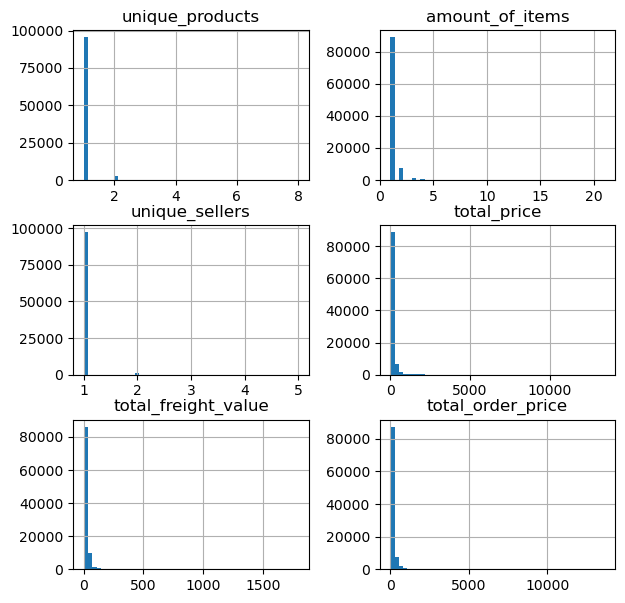

In [15]:
items_grouped_by_orders.hist(figsize=(7, 7), bins=50);

### Sellers

In [17]:
df_sellers.reset_index(inplace=True)

### Create Database

In [19]:
df_dict = {
    "items": df_items,
    "reviews": df_reviews,
    "orders": df_orders,
    "products": df_products,
    "geolocation": df_geolocation,
    "sellers": df_sellers,
    "payments": df_payments,
    "customers": df_customers,
    "category": df_category
}

In [20]:
db_path = "database_final.db"
with sqlite3.connect(db_path) as conn:
    for df_name, df in df_dict.items():
        df.to_sql(df_name, conn, if_exists='replace')

### FRM

In [22]:
with sqlite3.connect("database_final.db") as conn:
    df_orders_to_customers = pd.read_sql(    
        """ SELECT 
                orders.*, 
                customers.customer_unique_id
            FROM orders
            JOIN customers ON orders.customer_id = customers.customer_id
        """,
        con=conn
    )
print('len(df_orders_to_customers):', len(df_orders_to_customers))
df_orders_to_customers.head()

len(df_orders_to_customers): 96455


,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,9ef432eb-6251-2973-04e7-6186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4-830f-d042-20f7-54e42b4e5bff
1,1,53cdb2fc-8bc7-dce0-b674-1e2150273451,b0830fb4-747a-6c6d-20de-a0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b-275d-755c-9edb-36a90c618231
2,2,47770eb9-100c-2d0c-4494-6d9cf07ec65d,41ce2a54-c0b0-3bf3-443c-3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41-f6f9-fc3d-2a11-3cf8398680e8
3,3,949d5b44-dbf5-de91-8fe9-c16f97b45f8a,f8819746-5ea7-920a-dcdb-ec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf6-3193-a147-3d2e-66489a9ae977
4,4,ad21c59c-0840-e6cb-83a9-ceb5573f8159,8ab97904-e6da-ea88-66db-dbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f-9dd7-3dfe-e390-c9b22eb56dd6


In [23]:
print('Вот так выглядит статистика по кол-ву заказов:')
df_orders_to_customers[['order_id', 'customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').agg(
    total_orders=('order_id', 'count'),      # Количество заказов
    last_order_date=('order_purchase_timestamp', 'max')
).reset_index().sort_values(by='total_orders', ascending=False).head()

Вот так выглядит статистика по кол-ву заказов:


,customer_unique_id,total_orders,last_order_date
51421,8d50f5ea-df50-201c-cdce-dfb9e2ac8455,15,2018-08-20 19:14:26
22774,3e43e610-5506-432c-953e-165fb2acf44c,9,2018-02-27 18:36:39
10058,1b6c7548-a2a1-f903-7c1f-d3ddfed95f33,7,2018-02-14 13:22:12
73905,ca77025e-7201-e3b3-0c44-b472ff346268,7,2018-06-01 11:38:29
36700,6469f99c-1f9d-fae7-733b-25662e7f1782,7,2018-06-28 00:43:34


In [24]:
rfm_base = pd.merge(
    left=df_orders_to_customers[['order_id', 'customer_unique_id', 'order_purchase_timestamp']],
    right=items_grouped_by_orders[['order_id', 'total_order_price']],
    on='order_id'
)
rfm_base['order_purchase_timestamp'] = pd.to_datetime(rfm_base['order_purchase_timestamp'])  # object -> datetime
rfm_base

,order_id,customer_unique_id,order_purchase_timestamp,total_order_price
0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,7c396fd4-830f-d042-20f7-54e42b4e5bff,2017-10-02 10:56:33,38.71
1,53cdb2fc-8bc7-dce0-b674-1e2150273451,af07308b-275d-755c-9edb-36a90c618231,2018-07-24 20:41:37,141.46
2,47770eb9-100c-2d0c-4494-6d9cf07ec65d,3a653a41-f6f9-fc3d-2a11-3cf8398680e8,2018-08-08 08:38:49,179.12
3,949d5b44-dbf5-de91-8fe9-c16f97b45f8a,7c142cf6-3193-a147-3d2e-66489a9ae977,2017-11-18 19:28:06,72.20
4,ad21c59c-0840-e6cb-83a9-ceb5573f8159,72632f0f-9dd7-3dfe-e390-c9b22eb56dd6,2018-02-13 21:18:39,28.62
...,...,...,...,...
96450,9c5dedf3-9a92-7c1b-2549-525ed64a053c,6359f309-b166-b019-6dbf-7ad2ac62bb5a,2017-03-09 09:54:05,85.08
96451,63943bdd-c261-676b-46f0-1ca7ac2f7bd8,da62f9e5-7a76-d978-d02a-b5362c509660,2018-02-06 12:58:58,195.00
96452,83c1379a-015d-f1e1-3d02-aae0204711ab,737520a9-aad8-0b3f-bbda-d19b66b37b30,2017-08-27 14:46:43,271.01
96453,11c177c8-e977-25db-2631-073c19f07b62,5097a531-2c8b-157b-b7be-58ae360ef43c,2018-01-08 21:28:27,441.16


In [25]:
latest_purchase_date = rfm_base['order_purchase_timestamp'].max() + dt.timedelta(days=1)

rfm = rfm_base.groupby('customer_unique_id').agg(
    recency=('order_purchase_timestamp', lambda x: (latest_purchase_date - x.max()).days),
    frequency=('order_id', 'count'),
    monetary=('total_order_price', 'sum')
)
rfm

,recency,frequency,monetary
customer_unique_id,,,
0000366f-3b9a-7992-bf8c-76cfdf3221e2,112,1,141.90
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f,115,1,27.19
0000f46a-3911-fa3c-0805-444483337064,537,1,86.22
0000f6cc-b074-5a6a-4b88-665a16c9f078,321,1,43.62
0004aac8-4e0d-f4da-2b14-7fca70cf8255,288,1,196.89
...,...,...,...
fffcf5a5-ff07-b090-8bd4-e2dbc735a684,447,1,2067.42
fffea47c-d6d3-cc0a-88bd-621562a9d061,262,1,84.58
ffff371b-4d64-5b6e-cea2-44b27531430a,568,1,112.46


In [26]:
rfm.describe()

,recency,frequency,monetary
count,93336.000000,93336.000000,93336.000000
mean,237.903853,1.033417,165.169348
std,152.552964,0.209098,226.313356
min,1.000000,1.000000,9.590000
25%,114.000000,1.000000,63.010000
50%,219.000000,1.000000,107.780000
75%,346.000000,1.000000,182.495000
max,714.000000,15.000000,13664.080000


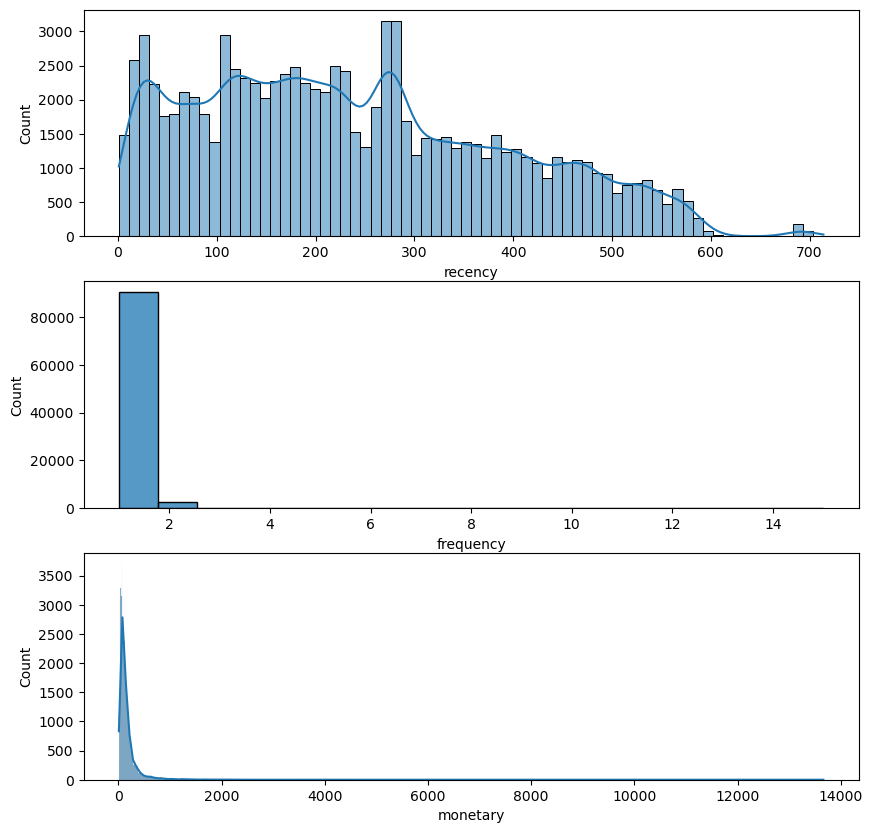

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
sns.histplot(rfm['recency'], ax=ax[0], kde=True)
sns.histplot(rfm['frequency'], ax=ax[1])
sns.histplot(rfm['monetary'], ax=ax[2], kde=True)
plt.show()

### RFM-сегментация

In [29]:
quantiles = rfm.quantile(q=[0.2,0.4,0.6,0.8])
quantiles = quantiles.to_dict()
    
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1   
    
def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5

In [30]:
rfm['R'] = rfm['recency'].apply(RScore, args=('recency',quantiles,))
rfm['F'] = rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
rfm['M'] = rfm['monetary'].apply(FMScore, args=('monetary',quantiles,))
rfm

,recency,frequency,monetary,R,F,M
customer_unique_id,,,,,,
0000366f-3b9a-7992-bf8c-76cfdf3221e2,112,1,141.90,4,1,4
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f,115,1,27.19,4,1,1
0000f46a-3911-fa3c-0805-444483337064,537,1,86.22,1,1,2
0000f6cc-b074-5a6a-4b88-665a16c9f078,321,1,43.62,2,1,1
0004aac8-4e0d-f4da-2b14-7fca70cf8255,288,1,196.89,2,1,4
...,...,...,...,...,...,...
fffcf5a5-ff07-b090-8bd4-e2dbc735a684,447,1,2067.42,1,1,5
fffea47c-d6d3-cc0a-88bd-621562a9d061,262,1,84.58,3,1,2
ffff371b-4d64-5b6e-cea2-44b27531430a,568,1,112.46,1,1,3


In [31]:
rfm['RFM_group'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_score'] = rfm[['R','F','M']].sum(axis=1)
rfm

,recency,frequency,monetary,R,F,M,RFM_group,RFM_score
customer_unique_id,,,,,,,,
0000366f-3b9a-7992-bf8c-76cfdf3221e2,112,1,141.90,4,1,4,414,9
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f,115,1,27.19,4,1,1,411,6
0000f46a-3911-fa3c-0805-444483337064,537,1,86.22,1,1,2,112,4
0000f6cc-b074-5a6a-4b88-665a16c9f078,321,1,43.62,2,1,1,211,4
0004aac8-4e0d-f4da-2b14-7fca70cf8255,288,1,196.89,2,1,4,214,7
...,...,...,...,...,...,...,...,...
fffcf5a5-ff07-b090-8bd4-e2dbc735a684,447,1,2067.42,1,1,5,115,7
fffea47c-d6d3-cc0a-88bd-621562a9d061,262,1,84.58,3,1,2,312,6
ffff371b-4d64-5b6e-cea2-44b27531430a,568,1,112.46,1,1,3,113,5


In [32]:
rfm.to_csv('rfm.csv')

<Axes: xlabel='RFM_score', ylabel='count'>

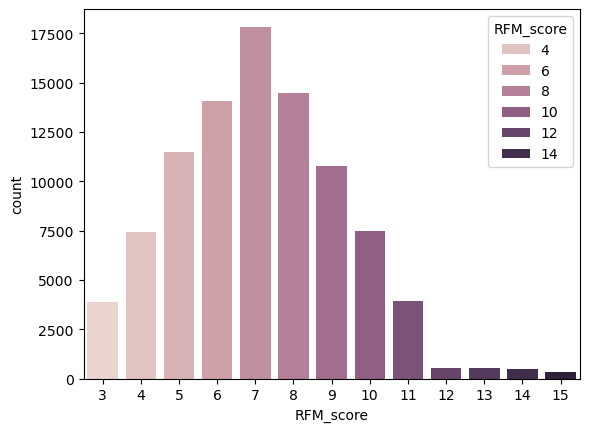

In [33]:
sns.countplot(data=rfm, x='RFM_score', hue='RFM_score')

<Axes: xlabel='RFM_group', ylabel='Count'>

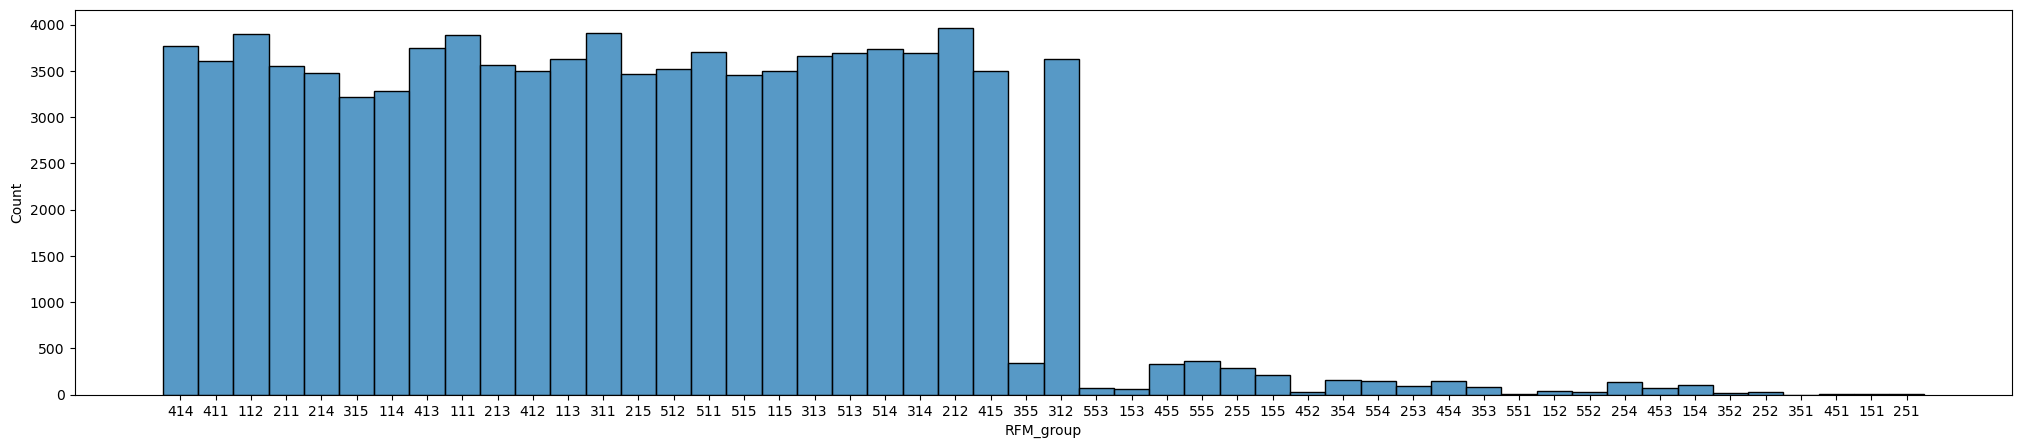

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(data=rfm, x='RFM_group')

In [35]:
rfm['RFM_group'].unique()

array(['414', '411', '112', '211', '214', '315', '114', '413', '111',
       '213', '412', '113', '311', '215', '512', '511', '515', '115',
       '313', '513', '514', '314', '212', '415', '355', '312', '553',
       '153', '455', '555', '255', '155', '452', '354', '554', '253',
       '454', '353', '551', '152', '552', '254', '453', '154', '352',
       '252', '351', '451', '151', '251'], dtype=object)

### K-means кластеризация

Для кластеризации надо приблизить распределение к нормальному

In [38]:
def view_distribution(critetion, visual=True):
    if visual:
        fig, ax = plt.subplots(2, 2, figsize=(10,7))
        sns.histplot(rfm[critetion], ax=ax[0,0], kde=True)
        sns.histplot(np.log(rfm[critetion]), ax=ax[0,1], kde=True)
        ax[0,1].set_title('log')
        sns.histplot(np.sqrt(rfm[critetion]), ax=ax[1,0], kde=True)
        ax[1,0].set_title('sqrt')
        sns.histplot(stats.boxcox(rfm[critetion])[0], ax=ax[1,1], kde=True)
        ax[1,1].set_title('boxcox')
        ax[1,1].set_xlabel('Recency')
        plt.tight_layout()
        plt.show()
    
    print(f'Преобразование логарифмированием: коэффициент асимметрии изменился с {rfm[critetion].skew().round(2)} до {np.log(rfm[critetion]).skew().round(2)}')
    print(f'Преобразование квадратного корня: коэффициент асимметрии изменился с {rfm[critetion].skew().round(2)} до {np.sqrt(rfm[critetion]).skew().round(2)}')
    print(f'Преобразование Бокса-Кокса: коэффициент асимметрии изменился с {rfm[critetion].skew().round(2)} до {pd.Series(stats.boxcox(rfm[critetion])[0]).skew().round(2)}')

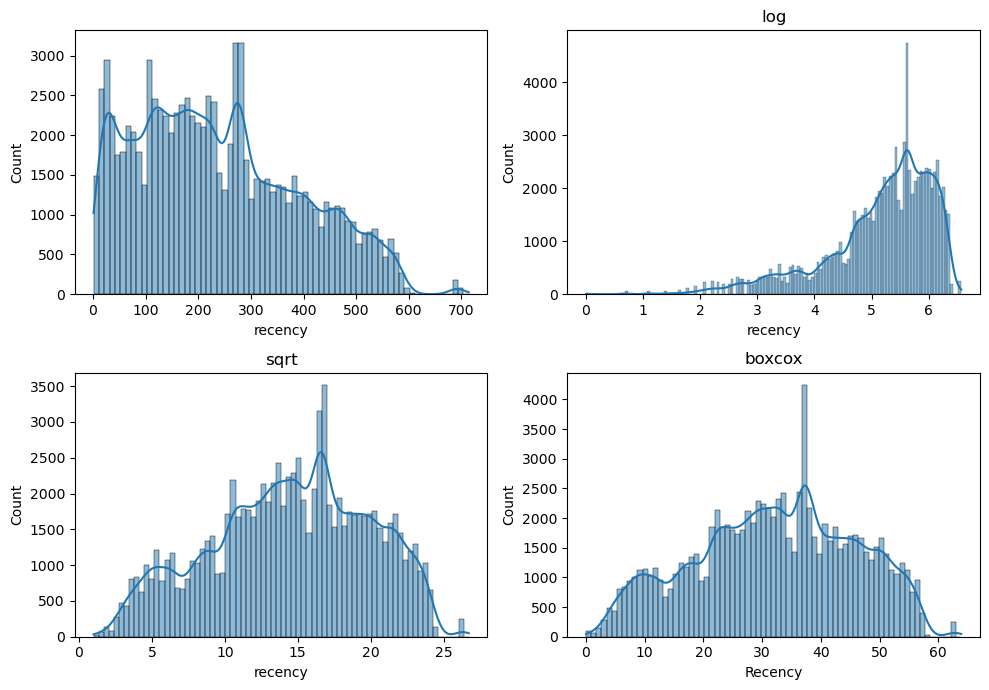

Преобразование логарифмированием: коэффициент асимметрии изменился с 0.45 до -1.29
Преобразование квадратного корня: коэффициент асимметрии изменился с 0.45 до -0.23
Преобразование Бокса-Кокса: коэффициент асимметрии изменился с 0.45 до -0.16


In [39]:
view_distribution('recency')

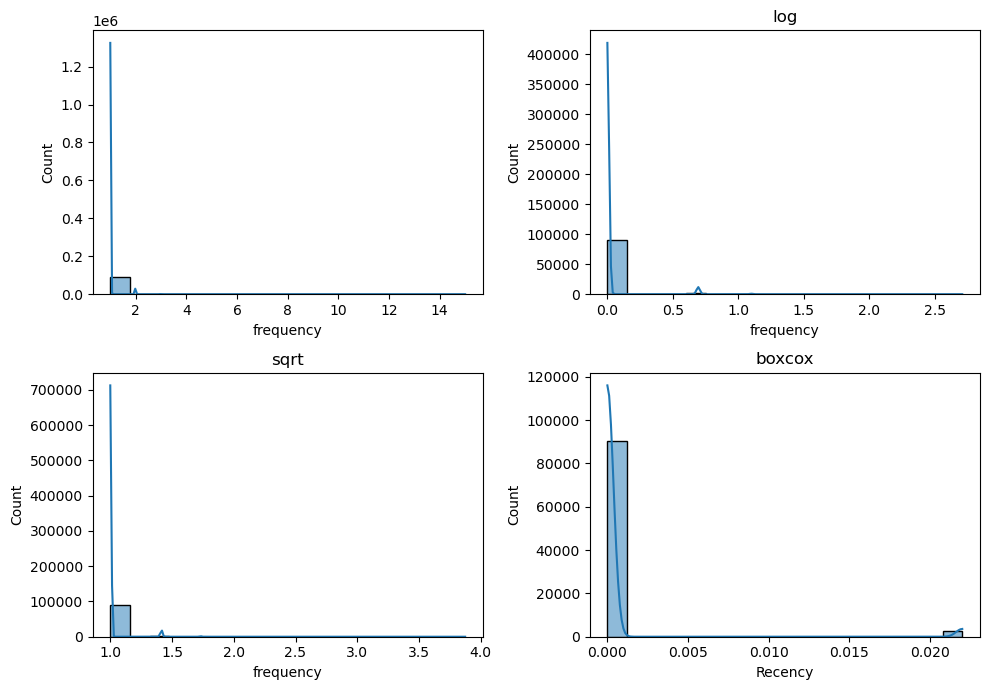

Преобразование логарифмированием: коэффициент асимметрии изменился с 11.1 до 6.09
Преобразование квадратного корня: коэффициент асимметрии изменился с 11.1 до 7.07
Преобразование Бокса-Кокса: коэффициент асимметрии изменился с 11.1 до 5.51


In [40]:
view_distribution('frequency')

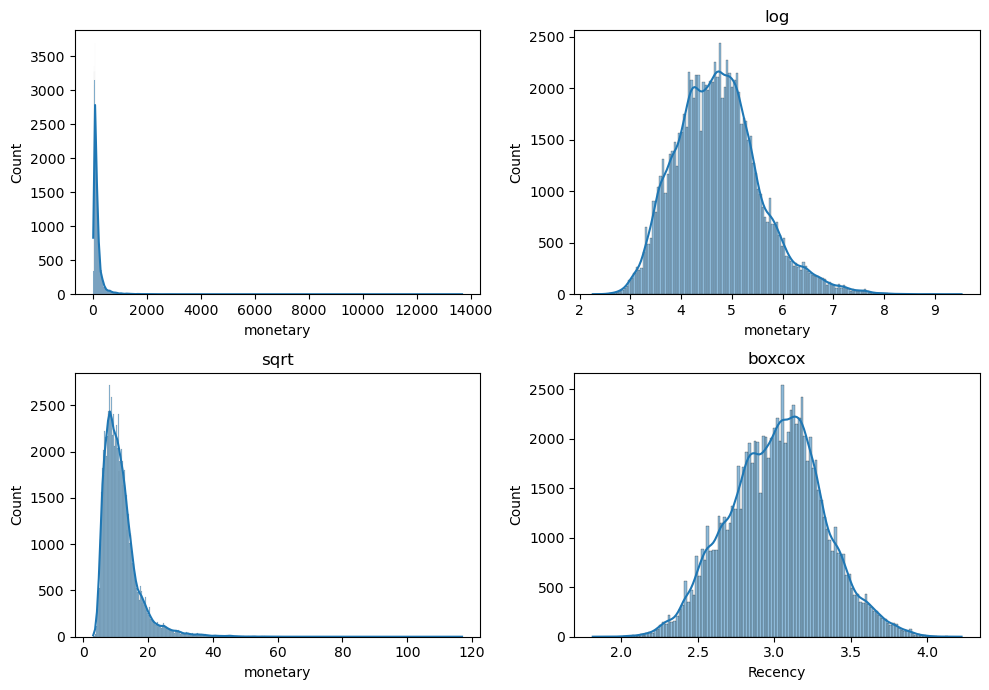

Преобразование логарифмированием: коэффициент асимметрии изменился с 9.21 до 0.51
Преобразование квадратного корня: коэффициент асимметрии изменился с 9.21 до 2.51
Преобразование Бокса-Кокса: коэффициент асимметрии изменился с 9.21 до 0.01


In [41]:
view_distribution('monetary')

На основе полученных результатов было принято решение об использовании преобразования Бокса-Кокса

In [43]:
rfm_tr = rfm[['recency', 'frequency', 'monetary']].copy()
rfm_tr['recency'] = stats.boxcox(rfm_tr['recency'])[0]
rfm_tr['frequency'] = stats.boxcox(rfm_tr['frequency'])[0]
rfm_tr['monetary'] = stats.boxcox(rfm_tr['monetary'])[0]

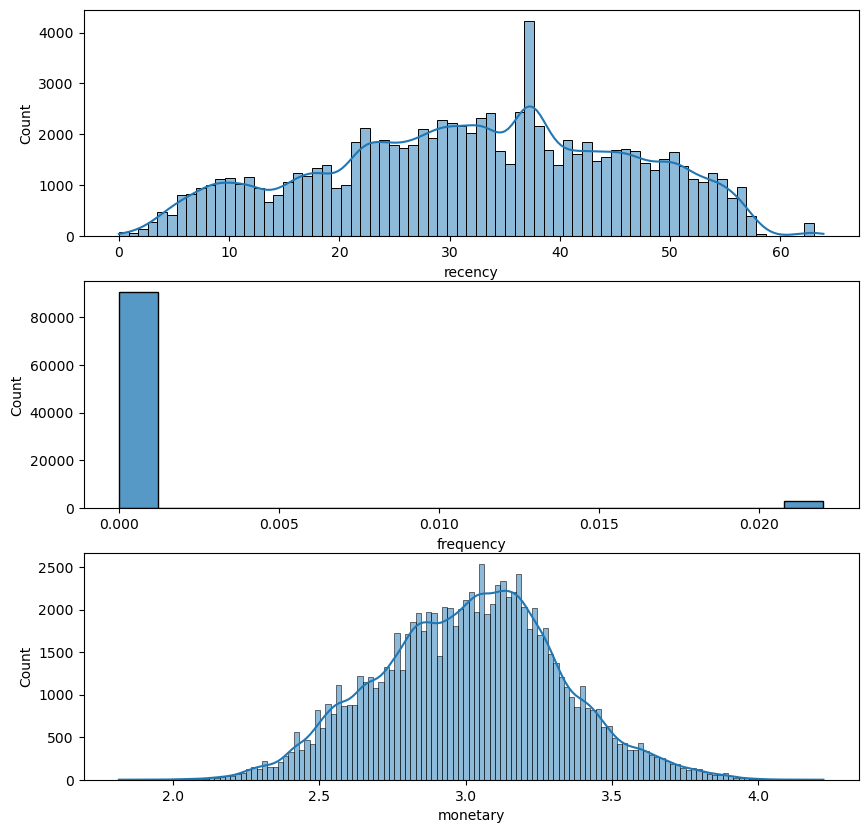

In [44]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
sns.histplot(rfm_tr['recency'], ax=ax[0], kde=True)
sns.histplot(rfm_tr['frequency'], ax=ax[1])
sns.histplot(rfm_tr['monetary'], ax=ax[2], kde=True)
plt.show()

Нормализуем данные. Использование StandardScaler проводится по всему датасету так как определение кол-ва кластеров лучше проводить на большой выборке. <br> Как итог, получим кол-во категорий пользователей, на определение самих категорий это в 

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_tr)
rfm_norm = scaler.fit_transform(rfm_tr[['recency', 'frequency', 'monetary']])
print("Вектор 'mean':", rfm_norm.mean(axis = 0).round(2)) 
print("Вектор 'std':", rfm_norm.std(axis = 0).round(2)) 

Вектор 'mean': [-0. -0.  0.]
Вектор 'std': [1. 1. 1.]


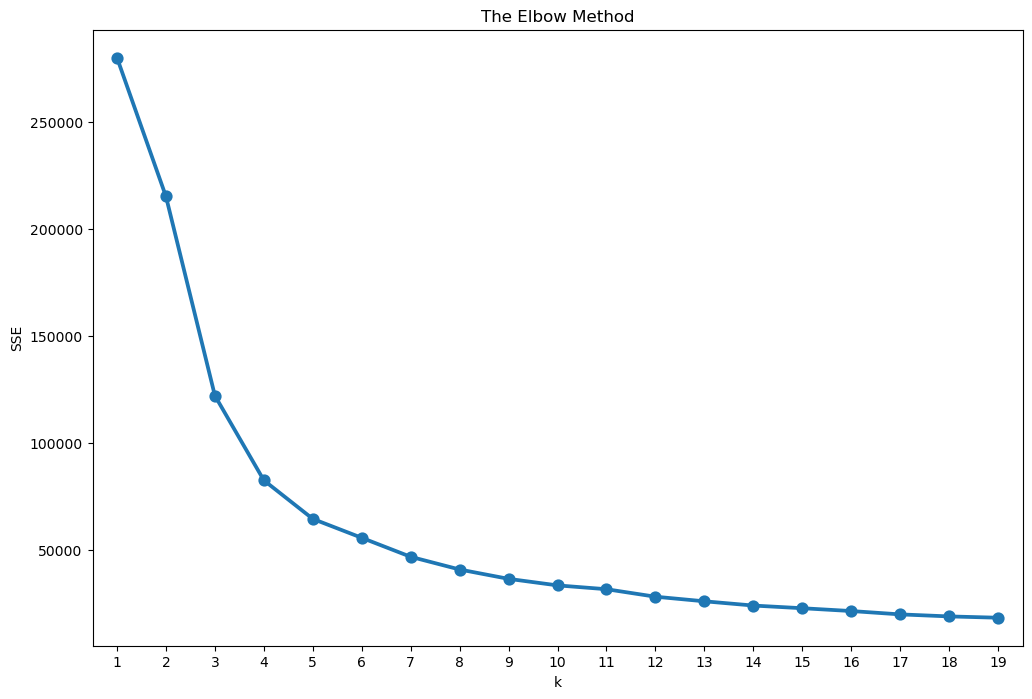

In [47]:
plt.figure(figsize=(12,8))

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(1, 20)
sse = {}

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(rfm_norm)    
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [48]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(rfm_norm)
model.labels_.shape

rfm["cluster"] = model.labels_
rfm.head()
rfm.groupby('cluster').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':['mean', 'count']}).round(1)

recency frequency monetary       
           mean      mean     mean  count
cluster                                  
0         321.0       1.0    271.8  31779
1          79.8       1.0    144.7  29551
2         309.1       1.0     56.1  29206
3         220.3       2.1    308.5   2800

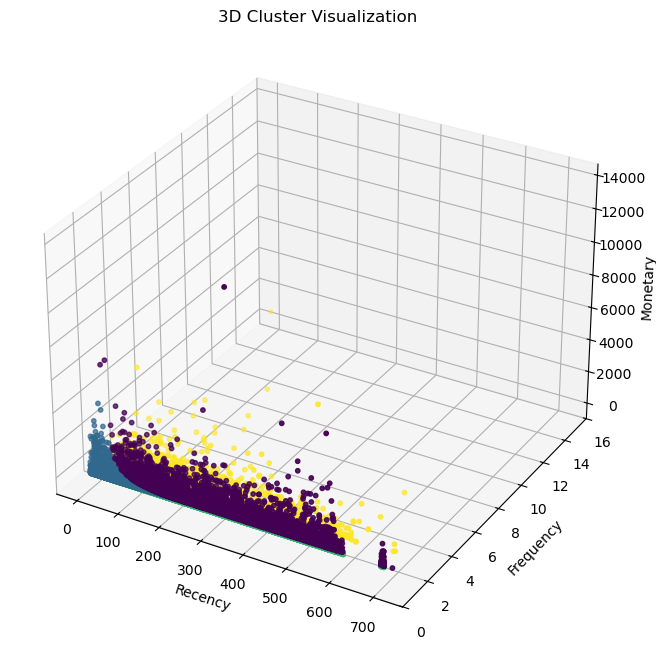

In [49]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm['recency'],
    rfm['frequency'],
    rfm['monetary'],
    c=rfm['cluster'],
    cmap='viridis',
    s=10
)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title("3D Cluster Visualization")
plt.show()

In [50]:
# Create the dataframe
rfm_norm = pd.DataFrame(rfm_norm, columns=['recency', 'frequency', 'monetary'])
rfm_norm['id'] = rfm.index
rfm_norm['cluster'] = model.labels_
rfm_norm.head()

,recency,frequency,monetary,id,cluster
0,-0.733530,-0.175861,0.373213,0000366f-3b9a-7992-bf8c-76cfdf3221e2,1
1,-0.707865,-0.175861,-1.964326,0000b849-f77a-49e4-a4ce-2b2a4ca5be3f,2
2,1.652667,-0.175861,-0.251343,0000f46a-3911-fa3c-0805-444483337064,2
3,0.637026,-0.175861,-1.214101,0000f6cc-b074-5a6a-4b88-665a16c9f078,2
4,0.456873,-0.175861,0.750799,0004aac8-4e0d-f4da-2b14-7fca70cf8255,0


In [51]:
rfm_norm_melt = pd.melt(rfm_norm.reset_index(),
                      id_vars=['id', 'cluster'],
                      value_vars=['recency', 'frequency', 'monetary'],
                      var_name='attribute',
                      value_name='value')
rfm_norm_melt.head()

,id,cluster,attribute,value
0,0000366f-3b9a-7992-bf8c-76cfdf3221e2,1,recency,-0.733530
1,0000b849-f77a-49e4-a4ce-2b2a4ca5be3f,2,recency,-0.707865
2,0000f46a-3911-fa3c-0805-444483337064,2,recency,1.652667
3,0000f6cc-b074-5a6a-4b88-665a16c9f078,2,recency,0.637026
4,0004aac8-4e0d-f4da-2b14-7fca70cf8255,0,recency,0.456873


<Axes: xlabel='attribute', ylabel='value'>

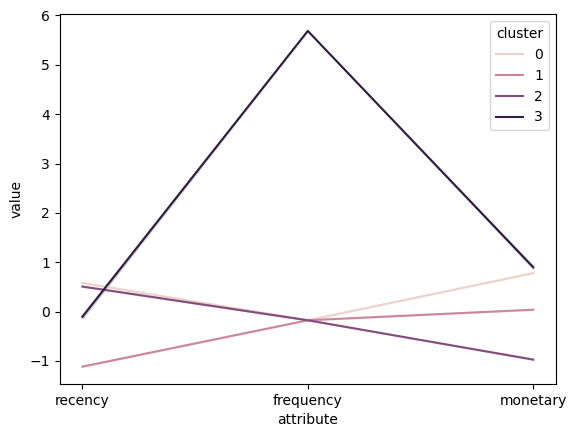

In [52]:
sns.lineplot(x='attribute', y='value', hue='cluster', data=rfm_norm_melt)